# Paper classification #

This notebook aims to classify research papers that belongs to six different categories:
1. Computer Science
2. Physics
3. Mathematics
4. Statistics
5. Quantitative Biology
6. Quantitative Finance

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
import kagglehub
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from sklearn.metrics import recall_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

## Dataset downloading and refining

In [2]:
# Download latest version of the dataset and save it into the path variable
path = kagglehub.dataset_download("shivanandmn/multilabel-classification-dataset")

# Load the dataset into a pandas dataframe
url_train = f'{path}/train.csv'
train_set  = pd.read_csv(url_train)

train_set.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [3]:

# Drop the ID column
train_set.drop(columns=['ID'], inplace=True)

# Combine the category columns into a list of categories for each paper
categories = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
train_set['Categories'] = train_set[categories].apply(lambda row: [cat for cat in categories if row[cat] == 1], axis=1)

train_set.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Categories
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,[Computer Science]
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,[Computer Science]
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,[Mathematics]
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,[Mathematics]
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[Computer Science, Statistics]"


## Dataset visualization

/tmp/ipykernel_22337/812583868.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


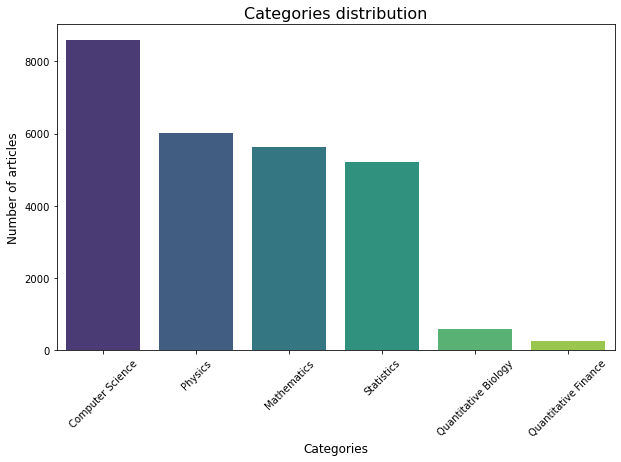

Number of occurrency for each category:
Computer Science: 8594
Physics: 6013
Mathematics: 5618
Statistics: 5206
Quantitative Biology: 587
Quantitative Finance: 249


In [4]:
# 1. Visualization of the distribution of the categories in the dataset
category_counts = train_set[categories].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Categories distribution", fontsize=16)
plt.ylabel("Number of articles", fontsize=12)
plt.xlabel("Categories", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Print the number of occurrencies for each category
print("Number of occurrency for each category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

As can be seen, the dataset is highly imbalanced

In [5]:
# Creating a new column that combines the title and the abstract
train_set['TEXT'] = train_set['TITLE'] + ' ' + train_set['ABSTRACT']

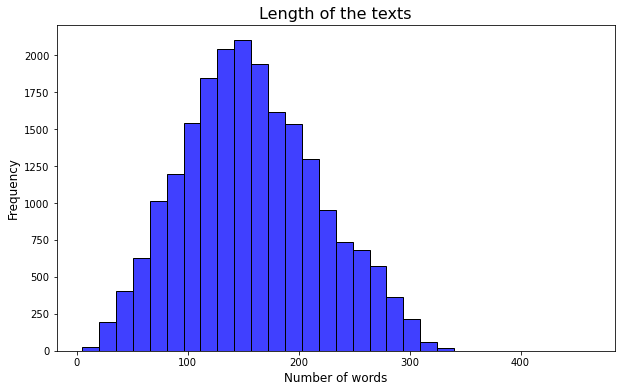

Mean length of the texts: 157.92 words


In [6]:
# 2. Exploring the length of the texts
# Adding a column that represents the length of the text
train_set['Text_Length'] = train_set['TEXT'].apply(lambda x: len(str(x).split()))
mean_lenght = train_set['Text_Length'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(train_set['Text_Length'], bins=30, color='blue')
plt.title("Length of the texts", fontsize=16)
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

# Print the mean length of the texts
print(f"Mean length of the texts: {mean_lenght:.2f} words")

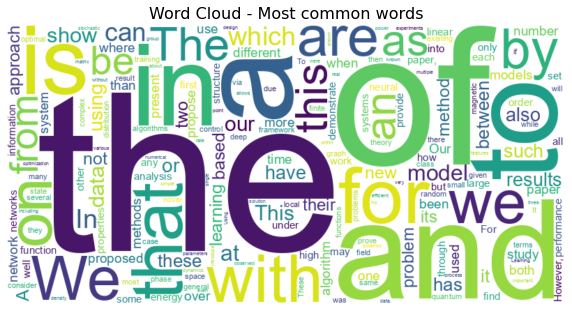

In [7]:
# 3. Creating a WordCloud to visualize the most common words in the texts
all_text = " ".join(str(text) for text in train_set['TEXT'])
word_freq = Counter(all_text.split())

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    font_path="./ARIAL.TTF" 
).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Most common words", fontsize=16)
plt.show()

## Dataset preprocessing 

In [8]:
# 1. Removing special characters and numbers and converting the text to lowercase
train_set['TITLE'] = train_set['TITLE'].str.lower().str.replace(r'[^\\w\\s]', '').str.replace(r'\\d+', '').str.strip()
train_set['ABSTRACT'] = train_set['ABSTRACT'].str.lower().str.replace(r'[^\\w\\s]', '').str.replace(r'\\d+', '').str.strip()
train_set['PROCESSED_TEXT'] = train_set['TITLE'] + ' ' + train_set['ABSTRACT']

In [9]:
# 2.1 Defining Function to load contractions from a file
def load_contractions(file_path):
    contractions_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            contraction, expansion = line.strip().split(',')
            contractions_dict[contraction] = expansion
    return contractions_dict

# 2.2 Defining Function to expand contractions based on a given file
def expand_contractions(text, file_path):
    contractions_dict = load_contractions(file_path)
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text

In [10]:
# 3. Removing stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

def remove_stop_words(text):
    words = [word for word in text.split() if word not in stop_words and len(word) > 1]
    return " ".join(words)

In [11]:
# 4. Lemmatization

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

# Function to get the wordnet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

def lemmatize_text(text):
    words = text.split()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return " ".join(lemmatized_words)

[nltk_data] Downloading package wordnet to /home/lolli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/lolli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/lolli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [12]:
# set contraction dictionary file path
contractions_file_path = './contractions.txt'


In [13]:
# Apply the preprocessing steps to the text
train_set['PROCESSED_TEXT'] = train_set['PROCESSED_TEXT'].apply(lambda x: expand_contractions(x, contractions_file_path))
train_set['PROCESSED_TEXT'] = train_set['PROCESSED_TEXT'].apply(remove_stop_words)
train_set['LEMMATIZED_TEXT'] = train_set['PROCESSED_TEXT'].apply(lemmatize_text)

In [14]:
print(train_set[['PROCESSED_TEXT', 'LEMMATIZED_TEXT']])

                                          PROCESSED_TEXT  \
0      reconstructing subject-specific effect maps pr...   
1      rotation invariance neural network rotation in...   
2      spherical polyharmonics poisson kernels polyha...   
3      finite element approximation stochastic maxwel...   
4      comparative study discrete wavelet transforms ...   
...                                                  ...   
20967  contemporary machine learning: guide practitio...   
20968  uniform diamond coatings wc-co hard alloy cutt...   
20969  analysing soccer games clustering conceptors p...   
20970  efficient simulation left-tail sum correlated ...   
20971  optional stopping problem bayesians recently, ...   

                                         LEMMATIZED_TEXT  
0      reconstruct subject-specific effect map predic...  
1      rotation invariance neural network rotation in...  
2      spherical polyharmonics poisson kernel polyhar...  
3      finite element approximation stochas

## Prepocessed dataset visualization

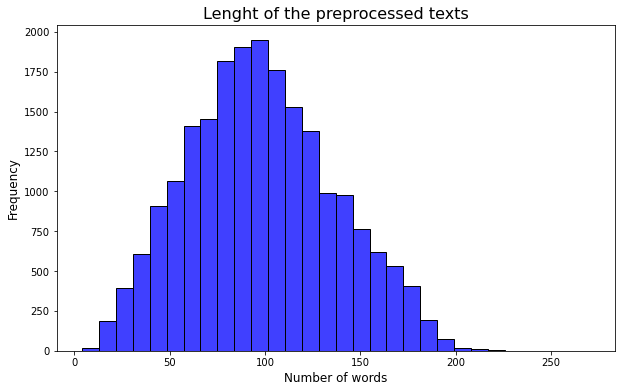

Mean length of the preprocessed texts: 98.03 words


In [15]:
# 2. Exploring the length of the preprocessed texts

train_set['Newtext_Length'] = train_set['LEMMATIZED_TEXT'].apply(lambda x: len(str(x).split()))
mean_lenght = train_set['Newtext_Length'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(train_set['Newtext_Length'], bins=30, color='blue')
plt.title("Lenght of the preprocessed texts", fontsize=16)
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

# Print the mean length of the texts
print(f"Mean length of the preprocessed texts: {mean_lenght:.2f} words")

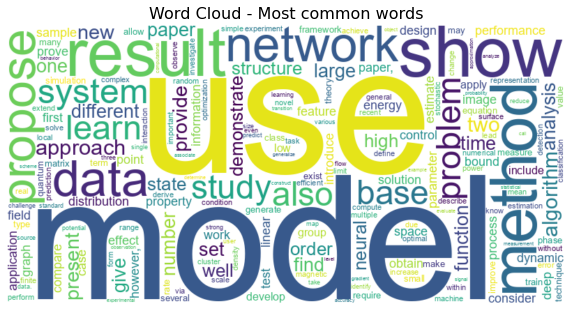

In [16]:
# 3. Creating a WordCloud to visualize the most common words in the preprocessed texts
all_text = " ".join(str(text) for text in train_set['LEMMATIZED_TEXT'])
word_freq = Counter(all_text.split())

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    font_path="./ARIAL.TTF" 
).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Most common words", fontsize=16)
plt.show()

## Training phase

In [17]:
# Creating a function to print the performance metrics
def print_metrics(f1, accuracy, recall):
    print("➡️ F1 Scores: ", f1)
    print("➡️ Accuracies: ", accuracy)
    print("➡️ Recall Scores: ", recall)
    print('---------------------------------')
    print("🙊​ Average F1 Score: ", sum(f1) / len(f1))
    print("🙊​ Average Accuracy Score: ", sum(accuracy) / len(accuracy))
    print("🙊​ Average Recall Score: ", sum(recall) / len(recall))

### 1. Training a logistic regression model on the non-processed dataset

In [18]:
1. # Binarize the labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_set['Categories'])

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(train_set['TEXT'])

In [19]:
kf = KFold(n_splits=10, shuffle=True)
f1_scores = []
accuracy_scores = []
recall_scores = []

ovr_classifier = OneVsRestClassifier(LogisticRegression())

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ovr_classifier.fit(X_train, y_train)
    y_pred = ovr_classifier.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred, average='micro'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred, average='micro'))

In [20]:
print_metrics(f1_scores, accuracy_scores, recall_scores)

➡️ F1 Scores:  [0.8000821018062397, 0.8027320208919244, 0.8029256399837464, 0.8135250050617534, 0.8084422110552764, 0.8132178118073746, 0.8146647761798663, 0.8036734693877551, 0.806497461928934, 0.8074660174477581]
➡️ Accuracies:  [0.6472831267874166, 0.6477597712106768, 0.6509298998569385, 0.6685741535526943, 0.6552217453505007, 0.6685741535526943, 0.659036719122556, 0.6533142584644731, 0.6556986170720076, 0.6504530281354316]
➡️ Recall Scores:  [0.7473159509202454, 0.7516930022573364, 0.7521888085268367, 0.767379679144385, 0.7574387947269303, 0.7693480747235989, 0.7663871951219512, 0.7555640828856485, 0.7594646271510517, 0.75579187238891]
---------------------------------
🙊​ Average F1 Score:  0.807322651555063
🙊​ Average Accuracy Score:  0.6556845473105389
🙊​ Average Recall Score:  0.7582572087846893


### 2. Training a logistic regression model on the processed dataset

In [21]:
# Binarize the labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_set['Categories'])

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(train_set['PROCESSED_TEXT'])

In [22]:
kf = KFold(n_splits=5, shuffle=True)
f1_scores = []
accuracy_scores = []
recall_scores = []

ovr_classifier = OneVsRestClassifier(LogisticRegression())

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ovr_classifier.fit(X_train, y_train)
    y_pred = ovr_classifier.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred, average='micro'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred, average='micro'))

In [23]:
print_metrics(f1_scores, accuracy_scores, recall_scores)

➡️ F1 Scores:  [0.8044385625572635, 0.804828565631974, 0.7990191069786451, 0.8086488681352147, 0.8113705583756345]
➡️ Accuracies:  [0.6555423122765197, 0.6495828367103695, 0.6442536957558417, 0.6552217453505007, 0.6611826418693372]
➡️ Recall Scores:  [0.7538637664567831, 0.7533232054690467, 0.7417947258584708, 0.7606951871657754, 0.7607081667618504]
---------------------------------
🙊​ Average F1 Score:  0.8056611323357463
🙊​ Average Accuracy Score:  0.6531566463925138
🙊​ Average Recall Score:  0.7540770103423853


### 3. Training other models on the processed dataset

In [24]:
classifiers = {
    "SVM": OneVsRestClassifier(LinearSVC()),
    "LGBM": OneVsRestClassifier(LGBMClassifier(n_estimators=100, random_state=42)),
    "NeuralNet": OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42))
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {clf_name: {"f1": [], "accuracy": [], "recall": []} for clf_name in classifiers.keys()}

# Test set
X_train = X  
y_train = y  

for clf_name, clf in classifiers.items():
    print(f"\n Training {clf_name}...")
    
    for train_index, test_index in kf.split(X_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]

        # Training
        clf.fit(X_tr, y_tr)
        
        # Prediction
        y_pred = clf.predict(X_te)

        # Metrics
        results[clf_name]["f1"].append(f1_score(y_te, y_pred, average='micro'))
        results[clf_name]["accuracy"].append(accuracy_score(y_te, y_pred))
        results[clf_name]["recall"].append(recall_score(y_te, y_pred, average='micro'))
    
    print(f"\n Results for {clf_name}:")



 Training SVM...

 Results for SVM:

 Training LGBM...


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6902, number of negative: 9875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315580
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6563
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411397 -> initscore=-0.358195
[LightGBM] [Info] Start training from score -0.358195


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4468, number of negative: 12309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315580
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6563
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266317 -> initscore=-1.013390
[LightGBM] [Info] Start training from score -1.013390


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4787, number of negative: 11990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315580
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6563
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285331 -> initscore=-0.918169
[LightGBM] [Info] Start training from score -0.918169


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 465, number of negative: 16312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315580
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6563
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027717 -> initscore=-3.557619
[LightGBM] [Info] Start training from score -3.557619


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 204, number of negative: 16573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315580
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6563
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012160 -> initscore=-4.397410
[LightGBM] [Info] Start training from score -4.397410


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4137, number of negative: 12640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315580
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6563
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.246588 -> initscore=-1.116896
[LightGBM] [Info] Start training from score -1.116896


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6876, number of negative: 9901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315312
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409847 -> initscore=-0.364599
[LightGBM] [Info] Start training from score -0.364599


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4500, number of negative: 12277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315312
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268224 -> initscore=-1.003650
[LightGBM] [Info] Start training from score -1.003650


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4781, number of negative: 11996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315312
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.284973 -> initscore=-0.919924
[LightGBM] [Info] Start training from score -0.919924


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 456, number of negative: 16321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315312
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027180 -> initscore=-3.577715
[LightGBM] [Info] Start training from score -3.577715


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 202, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.290222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315312
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012040 -> initscore=-4.407383
[LightGBM] [Info] Start training from score -4.407383


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4198, number of negative: 12579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315312
[LightGBM] [Info] Number of data points in the train set: 16777, number of used features: 6571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250224 -> initscore=-1.097421
[LightGBM] [Info] Start training from score -1.097421


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6920, number of negative: 9858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315202
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.412445 -> initscore=-0.353868
[LightGBM] [Info] Start training from score -0.353868


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4474, number of negative: 12304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315202
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266659 -> initscore=-1.011642
[LightGBM] [Info] Start training from score -1.011642


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4806, number of negative: 11972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315202
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286447 -> initscore=-0.912705
[LightGBM] [Info] Start training from score -0.912705


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 473, number of negative: 16305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315202
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028192 -> initscore=-3.540132
[LightGBM] [Info] Start training from score -3.540132


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 195, number of negative: 16583
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315202
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011622 -> initscore=-4.443134
[LightGBM] [Info] Start training from score -4.443134


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4169, number of negative: 12609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.289325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315202
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248480 -> initscore=-1.106735
[LightGBM] [Info] Start training from score -1.106735


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6824, number of negative: 9954
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315838
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6567
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406723 -> initscore=-0.377529
[LightGBM] [Info] Start training from score -0.377529


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4499, number of negative: 12279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.289891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315838
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6567
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268149 -> initscore=-1.004035
[LightGBM] [Info] Start training from score -1.004035


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4873, number of negative: 11905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315838
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6567
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290440 -> initscore=-0.893249
[LightGBM] [Info] Start training from score -0.893249


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 496, number of negative: 16282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315838
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6567
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029563 -> initscore=-3.491240
[LightGBM] [Info] Start training from score -3.491240


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199, number of negative: 16579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.367359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 315838
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6567
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011861 -> initscore=-4.422587
[LightGBM] [Info] Start training from score -4.422587


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4150, number of negative: 12628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315838
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6567
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247348 -> initscore=-1.112808
[LightGBM] [Info] Start training from score -1.112808


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6854, number of negative: 9924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315328
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6581
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408511 -> initscore=-0.370124
[LightGBM] [Info] Start training from score -0.370124


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4531, number of negative: 12247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315328
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6581
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270056 -> initscore=-0.994338
[LightGBM] [Info] Start training from score -0.994338


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4805, number of negative: 11973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315328
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6581
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286387 -> initscore=-0.912997
[LightGBM] [Info] Start training from score -0.912997


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 458, number of negative: 16320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.327960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315328
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6581
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027298 -> initscore=-3.573277
[LightGBM] [Info] Start training from score -3.573277


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 196, number of negative: 16582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315328
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6581
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011682 -> initscore=-4.437958
[LightGBM] [Info] Start training from score -4.437958


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4170, number of negative: 12608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.256422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315328
[LightGBM] [Info] Number of data points in the train set: 16778, number of used features: 6581
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248540 -> initscore=-1.106415
[LightGBM] [Info] Start training from score -1.106415


/home/lolli/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 Results for LGBM:

 Training NeuralNet...

 Results for NeuralNet:


In [25]:
for clf_name, metrics in results.items():
    print(f"\n Results for {clf_name}:")
    print_metrics(metrics["f1"], metrics["accuracy"], metrics["recall"])
    print('---------------------------------')


 Results for SVM:
➡️ F1 Scores:  [0.7977374683050517, 0.804945054945055, 0.8125981161695447, 0.8041116005873715, 0.8052870388636812]
➡️ Accuracies:  [0.635518474374255, 0.6426698450536352, 0.6549833094897473, 0.6475917978063901, 0.6463996185026228]
➡️ Recall Scores:  [0.7711161387631976, 0.7807384849638371, 0.7917782026768643, 0.7858783008036739, 0.7770797639444127]
---------------------------------
🙊​ Average F1 Score:  0.8049358557741408
🙊​ Average Accuracy Score:  0.6454326090453302
🙊​ Average Recall Score:  0.7813181782303971
---------------------------------

 Results for LGBM:
➡️ F1 Scores:  [0.803501180173092, 0.8011846001974333, 0.8090954028670292, 0.805361190499655, 0.803115449078182]
➡️ Accuracies:  [0.6419547079856972, 0.6381406436233611, 0.6475917978063901, 0.6390081068192656, 0.6409155937052933]
➡️ Recall Scores:  [0.7701734539969834, 0.7723639132089837, 0.7824091778202676, 0.7818599311136625, 0.7753664572625166]
---------------------------------
🙊​ Average F1 Score:  0.8